In [45]:
import numpy as np
import pandas as pd
import datetime
import statsmodels.tsa.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
warnings.filterwarnings("ignore")
from sklearn.metrics import mean_squared_error

In [46]:
df = pd.read_csv('../../data/cooked_data/cooked_complete_dataset.csv')

df["date"] = df["date"].apply(lambda x: datetime.datetime.strptime(x, "%d/%m/%y"))

train = df[df["date"] <= "2021/03/14"]
validation = df[(df["date"] > "2021/03/14") & (df['date'] <= '2021/03/29')]
test = df[(df["date"] > "2021/03/29")]

train.set_index('date', inplace = True)
validation.set_index('date', inplace = True)
test.set_index('date', inplace = True)

In [47]:
def tsplot(y, lags=20, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))    
        y.plot(ax=ts_ax)
        p_value = sm.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
    return

In [48]:
for col in train.columns:
    print(col, sm.adfuller(train[col])[1])

Adj_Close_BTC-USD 0.8172453866632154
Open_BTC-USD 0.8885818101279825
High_BTC-USD 0.8337054579909687
Low_BTC-USD 0.894558998411863
Volume_BTC-USD 3.269844024187802e-14
Adj_Close_SPY 0.30098140554244956
Adj_Close_GLD 0.8642970600261094
Adj_Close_CHFUSD=X 0.8838418049782971
Adj_Close_CNYUSD=X 0.10470326084539255
Adj_Close_EURUSD=X 0.49072654112537717
Adj_Close_GBPUSD=X 0.3215775201134091
Adj_Close_JPYUSD=X 0.9983034956127514
coindesk_sentiment 2.7005664144078556e-15
num_of_coindesk_posts 0.2356827799979101
reddit_comments_sentiments 1.0041770679115573e-12
top_50_reddit_posts_sentiments 4.717412877446624e-14
blockchain_transactions_per_block 0.02818050359086952
blockchain_hash_rates 0.23633810730362248


In [49]:
# differencing - first order sufficient
for col in train.columns:
    print(col, sm.adfuller(train.diff().dropna()[col])[1])

Adj_Close_BTC-USD 1.6607755073643516e-16
Open_BTC-USD 2.959534611956222e-16
High_BTC-USD 6.7012860478041856e-15
Low_BTC-USD 9.693805917906009e-15
Volume_BTC-USD 4.3143065139574474e-16
Adj_Close_SPY 2.8887323877585773e-16
Adj_Close_GLD 7.226552581967122e-08
Adj_Close_CHFUSD=X 1.9168226285193647e-15
Adj_Close_CNYUSD=X 2.7910380394131694e-09
Adj_Close_EURUSD=X 1.5318916436035794e-15
Adj_Close_GBPUSD=X 1.8337892775476304e-09
Adj_Close_JPYUSD=X 7.660665902668827e-05
coindesk_sentiment 4.3511569183561055e-09
num_of_coindesk_posts 0.0001656226805654693
reddit_comments_sentiments 2.5205356071194547e-10
top_50_reddit_posts_sentiments 3.382010112753078e-11
blockchain_transactions_per_block 0.0007240674904382872
blockchain_hash_rates 3.616619105826313e-10


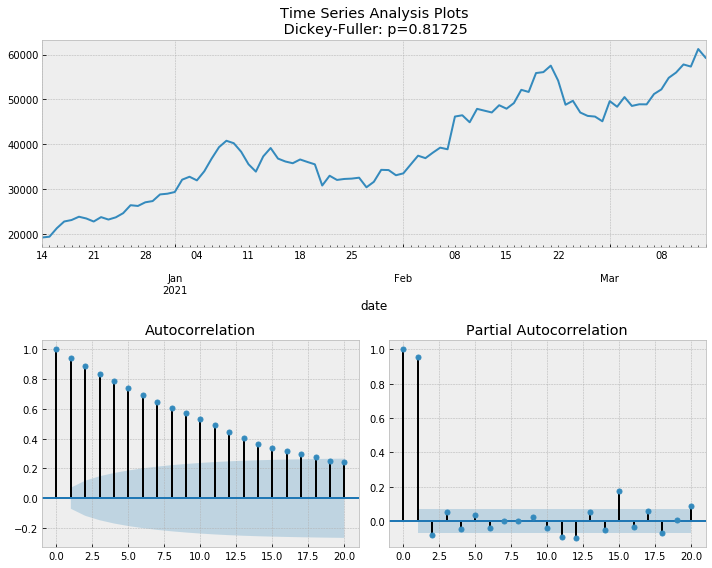

In [50]:
tsplot(train["Adj_Close_BTC-USD"])

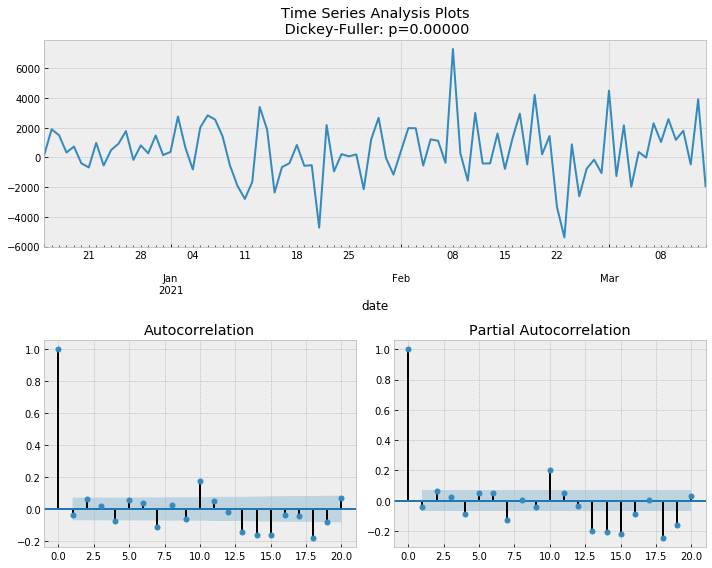

In [51]:
tsplot(train["Adj_Close_BTC-USD"].diff().dropna()) # white noise after differencing

In [52]:
df_differenced = train.diff().dropna()
df_differenced = df_differenced[["Adj_Close_BTC-USD","Adj_Close_SPY", "Adj_Close_GLD","Adj_Close_CHFUSD=X",
                                 "Adj_Close_EURUSD=X","Adj_Close_GBPUSD=X","Adj_Close_JPYUSD=X","blockchain_transactions_per_block",
                                 "blockchain_hash_rates", 'coindesk_sentiment', 'reddit_comments_sentiments', 
                                 'top_50_reddit_posts_sentiments']]

In [53]:
def write_results(results, columns):
    print(results.summary())
    print("================test_whiteness================\n")
    print(results.test_whiteness(nlags=10))
    print("================results.roots()================\n")
    for root in results.roots:
        print(str(root)+",")
    print("\n================is_stable================\n")
    print(str(results.is_stable()))
    print("\n================granger causality================\n")
    for V1 in ["Adj_Close_BTC-USD"]:
        for V2 in columns:
            print("Granger test: "+V2+"-->"+V1+"\n")
            print(results.test_causality(V1, [V2],kind='f').summary())
            print("\n")

## With Sentiment

In [54]:
all_rmse = {}
for lag_order in range(1,11):
    model = VAR(df_differenced)
    results = model.fit(lag_order,trend="c")
    
    # validation set forecasting
    pred_validation = results.forecast(results.y, steps=len(validation))[:,0]
    
    # un-differencing it
    pred_values = [train.loc["2021/03/14",'Adj_Close_BTC-USD']]
    for diff in pred_validation:
        pred_values.append(pred_values[-1] + diff)
    
    # calculate validation set rmse
    rmse = np.sqrt(mean_squared_error(validation["Adj_Close_BTC-USD"], pred_values[1:]))
    all_rmse[lag_order] = rmse

In [55]:
all_rmse # lag3 lowest

{1: 7307.828625065951,
 2: 7614.020803397407,
 3: 7291.20888797912,
 4: 9099.93806505787,
 5: 16530.220562330385,
 6: 9166.462528321958,
 7: 2802663.514932114,
 8: 80912.66542587512,
 9: 119290.65811256992,
 10: 56572.34220202906}

In [56]:
lag_order = 3
results = model.fit(lag_order,trend="c")
write_results(results, df_differenced.columns)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 23, Apr, 2021
Time:                     12:12:48
--------------------------------------------------------------------
No. of Equations:         12.0000    BIC:                    1.02397
Nobs:                     87.0000    HQIC:                  -6.49322
Log likelihood:          -534.483    FPE:                1.90497e-05
AIC:                     -11.5607    Det(Omega_mle):     2.71056e-07
--------------------------------------------------------------------
Results for equation Adj_Close_BTC-USD
                                           coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------------
const                                       327.885449       289.130653            1.134           0.257
L1.Adj_Close_BTC-USD                         -0.095557   

In [57]:
# training set forecast
pred_train = []
for timestep in range(df_differenced.shape[0] - lag_order + 1):
    pred_train.append(results.forecast(y=df_differenced.values[0:timestep+lag_order], steps=1)[0][0])

predictions_train = [None, None, df.loc[lag_order-1,'Adj_Close_BTC-USD']]
for diff in pred_train:
    predictions_train.append(predictions_train[-1] + diff)

In [58]:
# validation and test set forecast
pred_test = results.forecast(results.y, steps=len(validation) + len(test))[:,0]

predictions_test = [train.loc["2021/03/14",'Adj_Close_BTC-USD']]
for diff in pred_test:
    predictions_test.append(predictions_test[-1] + diff)

In [59]:
predictions = np.concatenate([predictions_train[3:], predictions_test[1:]])

In [60]:
prediction_all = pd.DataFrame(predictions, index = df.date[3:], columns = ['predicted'])
prediction_all['actual'] = df["Adj_Close_BTC-USD"].values[3:]

In [61]:
prediction_all.to_csv('with_sentiments.csv')

In [62]:
# train rmse
rmse_train = prediction_all.loc[:"2021/03/14"]
rmse = np.sqrt(mean_squared_error(rmse_train.actual, rmse_train.predicted))
print("RMSE : % f" %(rmse))

RMSE :  4737.807200


In [63]:
# test rmse
rmse_test = prediction_all.loc['2021/03/29':]
rmse = np.sqrt(mean_squared_error(rmse_test.actual, rmse_test.predicted))
print("RMSE : % f" %(rmse))

RMSE :  10177.265307


## Without Sentiment

In [64]:
df_differenced = train.diff().dropna()

df_differenced_no_sentiment = df_differenced.drop(['coindesk_sentiment', 'num_of_coindesk_posts', 
                                                   'reddit_comments_sentiments', 'top_50_reddit_posts_sentiments'], 
                                                  axis = 1)
df_differenced_no_sentiment = df_differenced_no_sentiment[["Adj_Close_BTC-USD","Adj_Close_SPY", "Adj_Close_GLD",
                                                           "Adj_Close_CHFUSD=X","Adj_Close_EURUSD=X", "Adj_Close_GBPUSD=X",
                                                           "Adj_Close_JPYUSD=X","blockchain_transactions_per_block",
                                                           "blockchain_hash_rates"]]

In [65]:
all_rmse = {}
for lag_order in range(1,11):
    model = VAR(df_differenced_no_sentiment)
    results = model.fit(lag_order,trend="c")
    
    # validation set forecasting
    pred_validation = results.forecast(results.y, steps=len(validation))[:,0]
    
    # un-differencing it
    pred_values = [train.loc["2021/03/14",'Adj_Close_BTC-USD']]
    for diff in pred_validation:
        pred_values.append(pred_values[-1] + diff)
    
    # calculate validation set rmse
    rmse = np.sqrt(mean_squared_error(validation["Adj_Close_BTC-USD"], pred_values[1:]))
    all_rmse[lag_order] = rmse

In [66]:
all_rmse # lag order 4

{1: 7367.5031067819,
 2: 7114.223494722179,
 3: 7299.9438463618035,
 4: 7097.613564204022,
 5: 8147.062358230886,
 6: 13402.567692746445,
 7: 12941.308211701997,
 8: 30708.87347719837,
 9: 40603.57799048638,
 10: 462063.287516016}

In [67]:
lag_order = 4
results = model.fit(lag_order,trend="c")
write_results(results, df_differenced_no_sentiment.columns)

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Fri, 23, Apr, 2021
Time:                     12:12:49
--------------------------------------------------------------------
No. of Equations:         9.00000    BIC:                    12.6682
Nobs:                     86.0000    HQIC:                   6.98947
Log likelihood:          -901.343    FPE:                    40.6035
AIC:                      3.16476    Det(Omega_mle):         1.62145
--------------------------------------------------------------------
Results for equation Adj_Close_BTC-USD
                                           coefficient       std. error           t-stat            prob
--------------------------------------------------------------------------------------------------------
const                                       247.392948       323.132263            0.766           0.444
L1.Adj_Close_BTC-USD                         -0.234953   

In [68]:
# training set forecast
pred_train = []
for timestep in range(df_differenced_no_sentiment.shape[0] - lag_order + 1):
    pred_train.append(results.forecast(y=df_differenced_no_sentiment.values[0:timestep+lag_order], steps=1)[0][0])

predictions_train = [df.loc[lag_order-1,'Adj_Close_BTC-USD']]
for diff in pred_train:
    predictions_train.append(predictions_train[-1] + diff)

In [69]:
# test set forecast
pred_test = results.forecast(results.y, steps=len(validation) + len(test))[:,0]

predictions_test = [train.loc["2021/03/14",'Adj_Close_BTC-USD']]
for diff in pred_test:
    predictions_test.append(predictions_test[-1] + diff)

In [70]:
predictions = np.concatenate([predictions_train[1:], predictions_test[1:]])

In [71]:
prediction_all = pd.DataFrame(predictions, index = df.date[4:], columns = ['predicted'])
prediction_all['actual'] = df["Adj_Close_BTC-USD"].values[4:]

In [72]:
prediction_all.to_csv('without_sentiments.csv')

In [73]:
# train rmse
rmse_train = prediction_all.loc[:"2021/03/14"]
rmse = np.sqrt(mean_squared_error(rmse_train.actual, rmse_train.predicted))
print("RMSE : % f" %(rmse))

RMSE :  5116.462933


In [74]:
# test rmse
rmse_test = prediction_all.loc['2021/03/29':]
rmse = np.sqrt(mean_squared_error(rmse_test.actual, rmse_test.predicted))
print("RMSE : % f" %(rmse))

RMSE :  10253.263514


In [75]:
# test rmse
rmse_test = prediction_all.loc['2021/03/29':]
rmse = np.sqrt(mean_squared_error(rmse_test.actual, rmse_test.predicted))
print("RMSE : % f" %(rmse))

RMSE :  10253.263514


In [76]:
prediction_all = pd.DataFrame(predictions, index = df.date[4:], columns = ['predicted'])
prediction_all['actual'] = df["Adj_Close_BTC-USD"].values[4:]

In [77]:
prediction_all.to_csv('without_sentiments.csv')

In [78]:
# train rmse
rmse_train = prediction_all.loc[:"2021/03/14"]
rmse = np.sqrt(mean_squared_error(rmse_train.actual, rmse_train.predicted))
print("RMSE : % f" %(rmse))

RMSE :  5116.462933


In [79]:
# test rmse
rmse_test = prediction_all.loc['2021/03/29':]
rmse = np.sqrt(mean_squared_error(rmse_test.actual, rmse_test.predicted))
print("RMSE : % f" %(rmse))

RMSE :  10253.263514
